In [1]:
import sys
print(sys.executable)


/Users/yogisharosarumaha/Documents/nba_analysis/venv/bin/python


In [2]:
!pip install pandas

In [3]:
!pip install kaggle

In [4]:
import os
import kaggle

os.environ['KAGGLE_USERNAME'] = 'your_username'
os.environ['KAGGLE_KEY'] = 'your_api_key'

!kaggle datasets download -d nathanlauga/nba-games -p dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/nathanlauga/nba-games
License(s): unknown
 99%|█████████████████████████████████████▌| 21.0M/21.2M [00:02<00:00, 16.1MB/s]
100%|██████████████████████████████████████| 21.2M/21.2M [00:02<00:00, 8.76MB/s]


# Convert to Parquet using Spark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DecimalType

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Convert CSV to Parquet") \
    .master("local[2]") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1")  \
    .config("spark.driver.memory", "1g") \
    .getOrCreate()


24/11/20 15:43:42 WARN Utils: Your hostname, Yogis-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.101.254.100 instead (on interface en0)
24/11/20 15:43:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 15:43:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:

# Define the schema for games_details
schema_games_details = StructType([
    StructField("GAME_ID", IntegerType()),
    StructField("TEAM_ID", IntegerType()),
    StructField("TEAM_ABBREVIATION", StringType()),
    StructField("TEAM_CITY", StringType()),
    StructField("PLAYER_ID", IntegerType()),
    StructField("PLAYER_NAME", StringType()),
    StructField("NICKNAME", StringType()),
    StructField("START_POSITION", StringType()),
    StructField("COMMENT", StringType()),
    StructField("MIN", StringType()),
    StructField("FGM", FloatType()),
    StructField("FGA", FloatType()),
    StructField("FG_PCT", FloatType()),
    StructField("FG3M", FloatType()),
    StructField("FG3A", FloatType()),
    StructField("FG3_PCT", FloatType()),
    StructField("FTM", FloatType()),
    StructField("FTA", FloatType()),
    StructField("FT_PCT", FloatType()),
    StructField("OREB", FloatType()),
    StructField("DREB", FloatType()),
    StructField("REB", FloatType()),
    StructField("AST", FloatType()),
    StructField("STL", FloatType()),
    StructField("BLK", FloatType()),
    StructField("TO", FloatType()),
    StructField("PF", FloatType()),
    StructField("PTS", FloatType()),
    StructField("PLUS_MINUS", FloatType()),
])


schema_games = StructType([
    StructField("GAME_DATE_EST", StringType(), True),
    StructField("GAME_ID", StringType(), True),
    StructField("GAME_STATUS_TEXT", StringType(), True),
    StructField("HOME_TEAM_ID", StringType(), True),
    StructField("VISITOR_TEAM_ID", StringType(), True),
    StructField("SEASON", IntegerType(), True),
    StructField("TEAM_ID_home", StringType(), True),
    StructField("PTS_home", IntegerType(), True),
    StructField("FG_PCT_home", FloatType(), True),
    StructField("FT_PCT_home", FloatType(), True),
    StructField("FG3_PCT_home", FloatType(), True),
    StructField("AST_home", IntegerType(), True),
    StructField("REB_home", IntegerType(), True),
    StructField("TEAM_ID_away", StringType(), True),
    StructField("PTS_away", IntegerType(), True),
    StructField("FG_PCT_away", FloatType(), True),
    StructField("FT_PCT_away", FloatType(), True),
    StructField("FG3_PCT_away", FloatType(), True),
    StructField("AST_away", IntegerType(), True),
    StructField("REB_away", IntegerType(), True),
    StructField("HOME_TEAM_WINS", IntegerType(), True),
])

schema_players = StructType([
    StructField("PLAYER_NAME", StringType(), True),
    StructField("TEAM_ID", StringType(), True),
    StructField("PLAYER_ID", StringType(), True),
    StructField("SEASON", IntegerType(), True)
])

schema_ranking = StructType([
    StructField("TEAM_ID", StringType(), True),
    StructField("LEAGUE_ID", StringType(), True),
    StructField("SEASON_ID", StringType(), True),
    StructField("STANDINGSDATE", StringType(), True),
    StructField("CONFERENCE", StringType(), True),
    StructField("TEAM", StringType(), True),
    StructField("G", IntegerType(), True),
    StructField("W", IntegerType(), True),
    StructField("L", IntegerType(), True),
    StructField("W_PCT", FloatType(), True),
    StructField("HOME_RECORD", StringType(), True),
    StructField("ROAD_RECORD", StringType(), True),
    StructField("RETURNTOPLAY", StringType(), True)
])

schema_teams = StructType([
    StructField("LEAGUE_ID", StringType(), True),
    StructField("TEAM_ID", StringType(), True),
    StructField("MIN_YEAR", StringType(), True),
    StructField("MAX_YEAR", StringType(), True),
    StructField("ABBREVIATION", StringType(), True),
    StructField("NICKNAME", StringType(), True),
    StructField("YEARFOUNDED", IntegerType(), True),
    StructField("CITY", StringType(), True),
    StructField("ARENA", StringType(), True),
    StructField("ARENACAPACITY", IntegerType(), True),
    StructField("OWNER", StringType(), True),
    StructField("GENERALMANAGER", StringType(), True),
    StructField("HEADCOACH", StringType(), True),
    StructField("DLEAGUEAFFILIATION", StringType(), True)
])




In [7]:
# Load the games_details data into a DataFrame with a defined schema
games_details_df = spark.read.csv(
    "dataset/games_details.csv", 
    header=True, 
    schema=schema_games_details
)

# Show the first few rows of the DataFrame to verify the data
games_details_df.show(n=5, truncate=False)

24/11/20 15:43:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+----------+-----------------+-----------+---------+--------------+--------+--------------+-------+-----+---+----+------+----+----+-------+---+----+------+----+----+---+---+---+---+---+---+----+----------+
|GAME_ID |TEAM_ID   |TEAM_ABBREVIATION|TEAM_CITY  |PLAYER_ID|PLAYER_NAME   |NICKNAME|START_POSITION|COMMENT|MIN  |FGM|FGA |FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA |FT_PCT|OREB|DREB|REB|AST|STL|BLK|TO |PF |PTS |PLUS_MINUS|
+--------+----------+-----------------+-----------+---------+--------------+--------+--------------+-------+-----+---+----+------+----+----+-------+---+----+------+----+----+---+---+---+---+---+---+----+----------+
|22200477|1610612759|SAS              |San Antonio|1629641  |Romeo Langford|Romeo   |F             |NULL   |18:06|1.0|1.0 |1.0   |0.0 |0.0 |0.0    |0.0|0.0 |0.0   |1.0 |1.0 |2.0|0.0|1.0|0.0|2.0|5.0|2.0 |-2.0      |
|22200477|1610612759|SAS              |San Antonio|1631110  |Jeremy Sochan |Jeremy  |F             |NULL   |31:01|7.0|14.0|0.5   |2.0 |4.0 |

In [9]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "dataset/games_details.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Print the data types of the columns
print("\nData types of the columns:")
print(df.dtypes)

# Print the column names to verify they match the expected schema
print("\nColumn names:")
print(df.columns)

# Check for any missing values in the DataFrame
print("\nChecking for missing values:")
print(df.isnull().sum())


/var/folders/y_/51s762l96md64s3q6nr4g3pw0000gn/T/ipykernel_11179/1464198128.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


First few rows of the DataFrame:
    GAME_ID     TEAM_ID TEAM_ABBREVIATION    TEAM_CITY  PLAYER_ID  \
0  22200477  1610612759               SAS  San Antonio    1629641   
1  22200477  1610612759               SAS  San Antonio    1631110   
2  22200477  1610612759               SAS  San Antonio    1627751   
3  22200477  1610612759               SAS  San Antonio    1630170   
4  22200477  1610612759               SAS  San Antonio    1630200   

      PLAYER_NAME NICKNAME START_POSITION COMMENT    MIN  ...  OREB  DREB  \
0  Romeo Langford    Romeo              F     NaN  18:06  ...   1.0   1.0   
1   Jeremy Sochan   Jeremy              F     NaN  31:01  ...   6.0   3.0   
2    Jakob Poeltl    Jakob              C     NaN  21:42  ...   1.0   3.0   
3   Devin Vassell    Devin              G     NaN  30:20  ...   0.0   9.0   
4       Tre Jones      Tre              G     NaN  27:44  ...   0.0   2.0   

   REB  AST  STL  BLK   TO   PF   PTS  PLUS_MINUS  
0  2.0  0.0  1.0  0.0  2.0  5.0   2.0

In [10]:
# Function to convert CSV to Parquet
def convert_csv_to_parquet(file_path, schema, output_path):
    df = spark.read.csv(file_path, header=True, schema=schema)
    df.write.parquet(output_path, mode='overwrite')

# Specify your file paths
convert_csv_to_parquet("dataset/games_details.csv", schema_games_details, "dataset/parquet/games_details")
convert_csv_to_parquet("dataset/games.csv", schema_games, "dataset/parquet/games")
convert_csv_to_parquet("dataset/players.csv", schema_players, "dataset/parquet/players")
convert_csv_to_parquet("dataset/ranking.csv", schema_ranking, "dataset/parquet/ranking")
convert_csv_to_parquet("dataset/teams.csv", schema_teams, "dataset/parquet/teams")


# Compare parquet and sql performance

Games CSV - Count: 26651, Time taken: 1.2104 seconds
Games Parquet - Count: 26651, Time taken: 0.4333 seconds
Players CSV - Count: 7228, Time taken: 0.3303 seconds
Players Parquet - Count: 7228, Time taken: 0.3192 seconds


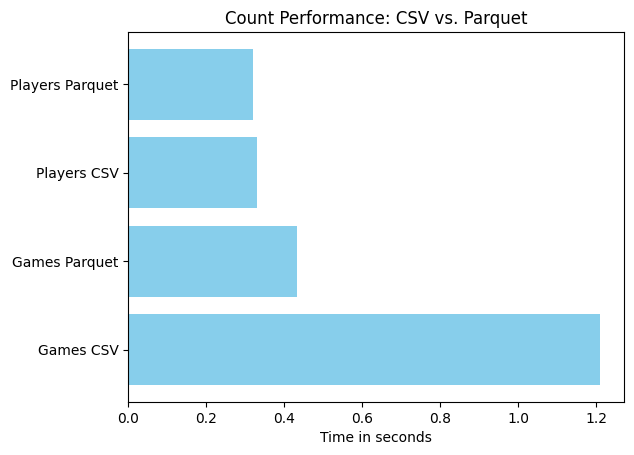

In [11]:
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt

# Define paths to your datasets
path_csv_games = "dataset/games.csv"
path_csv_players = "dataset/players.csv"  # Updated to players CSV
path_parquet_players = "dataset/parquet/players"  # Updated to players Parquet
path_parquet_games = "dataset/parquet/games"


# Load all Parquet files from the specified directory
df_games_parquet = spark.read.parquet(path_parquet_games)
df_players_parquet = spark.read.parquet(path_parquet_players)

# Initialize lists to store results for visualization
count_results = []

# Function to load data and benchmark simple count query
def benchmark_count(dataframe, description):
    start_time = time.time()
    count = dataframe.count()
    end_time = time.time()
    duration = end_time - start_time
    count_results.append((description, duration))
    print(f"{description} - Count: {count}, Time taken: {duration:.4f} seconds")


# Load and benchmark CSV and Parquet for 'games.csv'
df_games_csv = spark.read.csv(path_csv_games, header=True, inferSchema=True)
df_games_parquet = spark.read.parquet(path_parquet_games)

benchmark_count(df_games_csv, "Games CSV")
benchmark_count(df_games_parquet, "Games Parquet")

# Load and benchmark CSV and Parquet for 'players.csv'
df_players_csv = spark.read.csv(path_csv_players, header=True, inferSchema=True)
df_players_parquet = spark.read.parquet(path_parquet_players)

benchmark_count(df_players_csv, "Players CSV")
benchmark_count(df_players_parquet, "Players Parquet")


# Visualization for Count Benchmark
labels, times = zip(*count_results)
fig, ax = plt.subplots()
ax.barh(labels, times, color='skyblue')
ax.set_xlabel('Time in seconds')
ax.set_title('Count Performance: CSV vs. Parquet')
plt.show()

Players CSV Complex Query - Time taken for complex query: 1.4318 seconds
Players Parquet Complex Query - Time taken for complex query: 0.7061 seconds


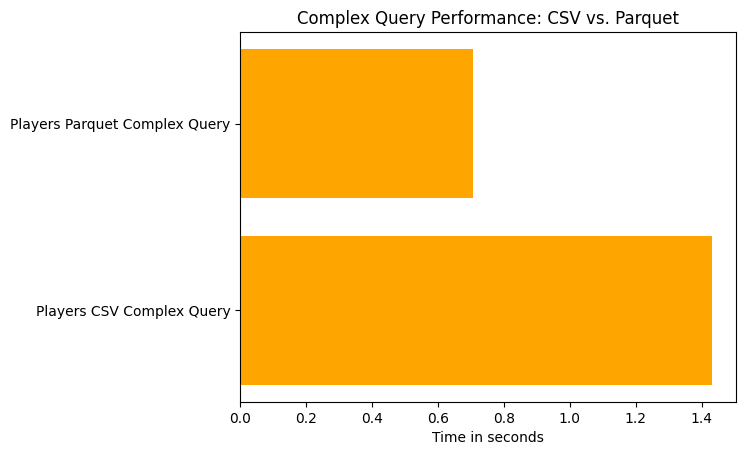

In [12]:
# Define paths to your datasets
path_csv_players = "dataset/players.csv"
path_parquet_players = "dataset/parquet/players"

# Load all Parquet files from the specified directory
df_players_csv = spark.read.csv(path_csv_players, header=True, inferSchema=True)
df_players_parquet = spark.read.parquet(path_parquet_players)

# Initialize lists to store results for visualization
query_results = []

# Function to perform a complex query and benchmark
def complex_query_benchmark(dataframe, description):
    start_time = time.time()
    result = dataframe.groupBy("TEAM_ID").avg("SEASON").collect()
    end_time = time.time()
    duration = end_time - start_time
    query_results.append((description, duration))
    print(f"{description} - Time taken for complex query: {duration:.4f} seconds")

# Complex Query Benchmarking
complex_query_benchmark(df_players_csv, "Players CSV Complex Query")
complex_query_benchmark(df_players_parquet, "Players Parquet Complex Query")



# Visualization for Complex Query Benchmark
labels, times = zip(*query_results)
fig, ax = plt.subplots()
ax.barh(labels, times, color='orange')
ax.set_xlabel('Time in seconds')
ax.set_title('Complex Query Performance: CSV vs. Parquet')
plt.show()

# Get Player Information 

In [14]:
import pandas as pd
import time
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams
import os

# Get all NBA team IDs
nba_teams = teams.get_teams()
team_ids = [team['id'] for team in nba_teams]

# Define the 2016-17 season
season = "2016-17"

# Fetch roster for each team in the 2016-17 season
all_rosters = []

# Function to fetch team roster with retries
def fetch_team_roster(team_id, season, max_retries=3, delay=5):
    for attempt in range(max_retries):
        try:
            # Fetch the roster
            roster = commonteamroster.CommonTeamRoster(team_id=team_id, league_id_nullable='00', season=season)
            df_roster = roster.get_data_frames()[0]
            # Select specific columns
            df_roster = df_roster[[
                "TeamID", "SEASON", "LeagueID", "PLAYER", "POSITION",
                "HEIGHT", "WEIGHT", "BIRTH_DATE", "AGE", "SCHOOL"
            ]]
            return df_roster
        except Exception as e:
            print(f"Attempt {attempt + 1} failed for TeamID: {team_id}, Season: {season} - {e}")
            if attempt < max_retries - 1:  # Only delay if there are remaining retries
                time.sleep(delay)
    return None  # Return None if all retries fail

# Loop through team IDs and fetch their rosters
for team_id in team_ids:
    df_roster = fetch_team_roster(team_id, season)
    if df_roster is not None:
        all_rosters.append(df_roster)
    else:
        print(f"Failed to fetch roster for TeamID: {team_id}, Season: {season} after multiple attempts.")

# Combine all rosters into a single DataFrame
df_all_rosters = pd.concat(all_rosters, ignore_index=True)

# Replace NaN with None
df_all_rosters = df_all_rosters.where(pd.notnull(df_all_rosters), None)

# Define the output Parquet file path
parquet_path = 'dataset/parquet/nba_team_rosters_2016_17.parquet'

# Ensure the directory exists
os.makedirs(os.path.dirname(parquet_path), exist_ok=True)

# Save the DataFrame to a Parquet file
df_all_rosters.to_parquet(parquet_path, index=False, engine='pyarrow')

print(f"Player roster for 2016-17 season saved successfully as {parquet_path}!")


Player roster for 2016-17 season saved successfully as dataset/nba_team_rosters_2016_17.csv!


# Data Ingestion to Snowflake

In [15]:
# Testing Connection

import os
from dotenv import load_dotenv
import snowflake.connector

# Load environment variables from .env file
load_dotenv()

def test_snowflake_connection():
    # Setup connection to Snowflake
    ctx = snowflake.connector.connect(
        user=os.getenv('SNOWFLAKE_USER'),
        password=os.getenv('SNOWFLAKE_PASSWORD'),
        account=os.getenv('SNOWFLAKE_ACCOUNT'),
        warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
        database=os.getenv('SNOWFLAKE_DATABASE'),
        schema=os.getenv('SNOWFLAKE_SCHEMA')
    )
    
    try:
        # Create a cursor object
        cur = ctx.cursor()
        
        # Execute a query
        cur.execute("SELECT CURRENT_VERSION()")
        
        # Fetch one result
        one_row = cur.fetchone()
        print("Connected to Snowflake! The version is:", one_row[0])
    
    except Exception as e:
        print("Failed to query Snowflake:", e)
    
    finally:
        cur.close()
        ctx.close()

if __name__ == "__main__":
    test_snowflake_connection()


Connected to Snowflake! The version is: 8.43.0


In [17]:
import os
import pandas as pd
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Establish connection to Snowflake
ctx = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database=os.getenv('SNOWFLAKE_DATABASE'),
    schema=os.getenv('SNOWFLAKE_SCHEMA'),
    role=os.getenv('SNOWFLAKE_ROLE')
)

def upload_dataframe_to_snowflake(df, table_name):
    try:
        # Data type conversion: ensure numeric fields are in the correct format
        if 'TEAMID' in df.columns:
            df['TEAMID'] = pd.to_numeric(df['TEAMID'], errors='coerce')
        if 'WEIGHT' in df.columns:
            df['WEIGHT'] = pd.to_numeric(df['WEIGHT'], errors='coerce')
        if 'AGE' in df.columns:
            df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')

        # Upload data to Snowflake
        success, nchunks, nrows, _ = write_pandas(ctx, df, table_name, auto_create_table=True)
        print(f"Successfully uploaded {nrows} rows and {nchunks} chunks to {table_name}.")
    except Exception as e:
        print(f"Failed to upload data to {table_name}: {e}")

# Dictionary mapping table names to Parquet directories or files
parquet_dirs = {
    'games': 'dataset/parquet/games',
    'games_details': 'dataset/parquet/games_details',
    'players': 'dataset/parquet/players',
    'ranking': 'dataset/parquet/ranking',
    'teams': 'dataset/parquet/teams',
    'player_information': 'dataset/parquet/nba_team_rosters_2016_17.parquet'  # Parquet version of player information
}

# Process each Parquet directory or file and upload its contents to Snowflake
for table_name, directory in parquet_dirs.items():
    if os.path.isfile(directory):  # If it's a file
        df_parquet = pd.read_parquet(directory)
        upload_dataframe_to_snowflake(df_parquet, table_name.upper())
    elif os.path.isdir(directory):  # If it's a directory
        for file_name in os.listdir(directory):
            if file_name.endswith('.parquet'):
                file_path = os.path.join(directory, file_name)
                df_parquet = pd.read_parquet(file_path)
                upload_dataframe_to_snowflake(df_parquet, table_name.upper())
    else:
        print(f"Skipped {directory}: Not a file or directory.")

# Close the connection
ctx.close()


CSV file not found: dataset/csv/nba_team_rosters_2016_17.csv
Successfully uploaded 26651 rows and 1 chunks to GAMES.
Successfully uploaded 315922 rows and 1 chunks to GAMES_DETAILS.
Failed to upload data to GAMES_DETAILS: 100038 (22018): Numeric value 'Romeo' is not recognized
Successfully uploaded 7228 rows and 1 chunks to PLAYERS.
Successfully uploaded 133051 rows and 1 chunks to RANKING.
Successfully uploaded 77291 rows and 1 chunks to RANKING.
Successfully uploaded 30 rows and 1 chunks to TEAMS.
Successfully uploaded 435 rows and 1 chunks to PLAYER_INFORMATION.
